# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    df = pd.read_csv(path_to_csv).sample(frac=1).reset_index(drop=True)
    return df.drop(columns='label').to_numpy(), df['label'].apply(lambda row: 1 if row == 'B' else 0).to_numpy()
    
def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    df = pd.read_csv(path_to_csv).sample(frac=1).reset_index(drop=True)
    return df.drop(columns='label').to_numpy(), df['label'].to_numpy()
    raise NotImplementedError()

In [3]:
read_cancer_dataset("cancer.csv")

(array([[1.305e+01, 1.931e+01, 8.261e+01, ..., 1.111e-02, 2.439e-01,
         6.289e-02],
        [1.065e+01, 2.522e+01, 6.801e+01, ..., 6.136e-02, 3.409e-01,
         8.147e-02],
        [1.152e+01, 1.875e+01, 7.334e+01, ..., 6.316e-02, 3.306e-01,
         7.036e-02],
        ...,
        [1.478e+01, 2.394e+01, 9.740e+01, ..., 1.614e-01, 3.321e-01,
         8.911e-02],
        [1.919e+01, 1.594e+01, 1.263e+02, ..., 1.777e-01, 2.443e-01,
         6.251e-02],
        [1.194e+01, 1.824e+01, 7.571e+01, ..., 6.296e-02, 2.785e-01,
         7.408e-02]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
        1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
 

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [4]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    df = pd.DataFrame(X)
    df['label'] = y
    
    train_size = int(ratio * len(df.index))
    test_size = len(df.index) - train_size
        
    df_train, df_test = df.head(train_size), df.tail(test_size)
        
    return df_train.drop(columns='label').to_numpy(), df_train['label'].to_numpy(), \
           df_test.drop(columns='label').to_numpy(), df_test['label'].to_numpy()
    
train_test_split(read_cancer_dataset("cancer.csv")[0], read_cancer_dataset("cancer.csv")[1], 0.9)

(array([[2.171e+01, 1.725e+01, 1.409e+02, ..., 1.820e-01, 2.510e-01,
         6.494e-02],
        [1.320e+01, 1.743e+01, 8.413e+01, ..., 4.970e-02, 2.767e-01,
         7.198e-02],
        [1.720e+01, 2.452e+01, 1.142e+02, ..., 1.899e-01, 3.313e-01,
         1.339e-01],
        ...,
        [1.519e+01, 1.321e+01, 9.765e+01, ..., 8.178e-02, 2.487e-01,
         6.766e-02],
        [1.386e+01, 1.693e+01, 9.096e+01, ..., 1.654e-01, 3.630e-01,
         1.059e-01],
        [1.822e+01, 1.887e+01, 1.187e+02, ..., 1.776e-01, 2.812e-01,
         8.198e-02]]),
 array([1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,
 

### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [5]:
def get_tp(class_name, y_pred, y_true):
    y_class = np.full(len(y_pred), class_name)
    tp = 0
    for i, val in enumerate(y_class):
        tp += int(val == y_pred[i] == y_true[i])
    return tp

def get_fp(class_name, y_pred, y_true):
    y_class = np.full(len(y_pred), class_name)
    fp = 0
    for i, val in enumerate(y_class):
        fp += int(val == y_pred[i] != y_true[i])
    return fp

def get_fn(class_name, y_pred, y_true):
    y_class = np.full(len(y_pred), class_name)
    fn = 0
    for i, val in enumerate(y_class):
        fn += int(val == y_true[i] != y_pred[i])
    return fn
    

def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    classes = np.unique(np.concatenate((y_pred, y_true), axis=None))
    df = pd.DataFrame()
    df['name'] = classes
    df['TP'] = df.apply(lambda row: get_tp(row['name'], y_pred, y_true), axis=1)
    df['FP'] = df.apply(lambda row: get_fp(row['name'], y_pred, y_true), axis=1)
    df['FN'] = df.apply(lambda row: get_fn(row['name'], y_pred, y_true), axis=1)
    df['recall'] = df.apply(lambda row: row['TP']/(row['TP'] + row['FN']), axis=1)
    df['precision'] = df.apply(lambda row: row['TP']/(row['TP'] + row['FP']), axis=1)
    
    accuracy = 0
    for i, val in enumerate(y_pred):
        accuracy += int(val == y_true[i])
    return  df['precision'].to_numpy(), df['recall'].to_numpy(), accuracy/len(y_pred)

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [6]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [7]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [8]:
class KDTree:
    axis_num = None
    
    root = None
    
    hash_map = dict()
    
    def build(self, X: np.array, leaf_size: int, depth=0):
        n = depth % self.axis_num
        sorted_X = sorted(X, key=lambda point: point[n])

        len_X = len(X)
        
        if len_X <= leaf_size * 2 + 1:
            return {
                'point': sorted_X,
                'list': True,
                'left': None,
                'right': None,
                'axis': n
            }
        
        return {
            'point': sorted_X[len_X // 2],
            'list': False,
            'left': self.build(sorted_X[:len_X // 2], depth + 1),
            'right': self.build(sorted_X[len_X // 2 + 1:], depth + 1),
            'axis': n
        }   
    

    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области, 
            в которых не меньше leaf_size точек).

        Returns
        -------

        """    
        self.axis_num = len(X[0])
        
        self.hash_map = dict()
        
        for i, val in enumerate(X):
            self.hash_map[str(val)] = i
        
        self.root = self.build(X, leaf_size) 
        
        
        
        
        
        
        
    def get_distance(self, point1, point2):
        
        return np.sum((point1 - point2) ** 2)

    def get_max_distance(self, point1, point_arr):
        maxi = -1
        for point in point_arr:
            maxi = max(maxi, self.get_distance(point1, point))
        return maxi

    def relax(self, pivot, point1, point2, k):
        return sorted(point1 + point2, key=lambda point: self.get_distance(pivot, point))[:k]  
    
    def get_points(self, node, point, k):
        nearest = None
        not_nearest = None

        n = node['axis']
        
        if not node['list']:
            if point[n] < node['point'][n]:
                nearest = node['left']
                not_nearest = node['right']
            else:
                nearest = node['right']
                not_nearest = node['left']
            
            tmp_points = self.get_points(nearest, point, k)

            if self.get_max_distance(point, tmp_points) > \
                        (point[n] - node['point'][n]) ** 2:
                tmp_points = self.relax(point, self.get_points(not_nearest, point, k) + [node['point']], tmp_points, k)
            elif len(tmp_points) < k:
                tmp_points = self.relax(point, self.get_points(not_nearest, point, k) + [node['point']], tmp_points, k)
            return tmp_points
        else:
            return self.relax(point, [], node['point'], k)
            
    
    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k): 
            индексы k ближайших соседей для всех точек из X.

        """
        ans = []
        for point in X:
            tmp_arr = []
            
            for j in self.get_points(self.root, point, k):
                tmp_arr.append(self.hash_map[str(j)])
            ans.append(tmp_arr)
        return ans
            

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [43]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 15)
X_test = np.random.randn(10, 15)
tree = KDTree(X_train, leaf_size=10)
predicted = tree.query(X_test, k=5)
true = true_closest(X_train, X_test, k=5)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [11]:
class KNearest:
    
    tree = None
    n_neighbors = None
    leaf_size = None
    y_train = None
    classes = None
    class_to_indexes = None
    
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.
 
        """        
        
        self.tree = KDTree(X, leaf_size=self.leaf_size)
        self.y_train = y
        self.classes = sorted(np.unique(y))
        self.class_to_indexes = dict()
        for clas in self.classes: 
            self.class_to_indexes[clas] = []
            for i in range(0, len(y)):
                if y[i] == clas:
                    self.class_to_indexes[clas].append(i)
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        ans_arr = []
        predicted = self.tree.query(X, k=self.n_neighbors)
        for ind, x in enumerate(X):
            tmp_arr = []
            for clas in self.classes:
                summ = 0
                for i in predicted[ind]:
                    if i in self.class_to_indexes[clas]:
                        summ += 1
                tmp_arr.append(summ / len(predicted))
            ans_arr.append(np.array(tmp_arr))
        
        return ans_arr
        
        
        
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            
        """ 
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

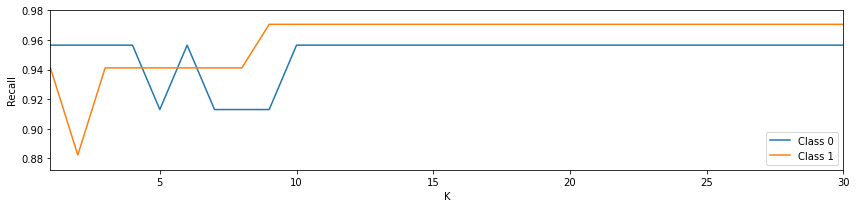

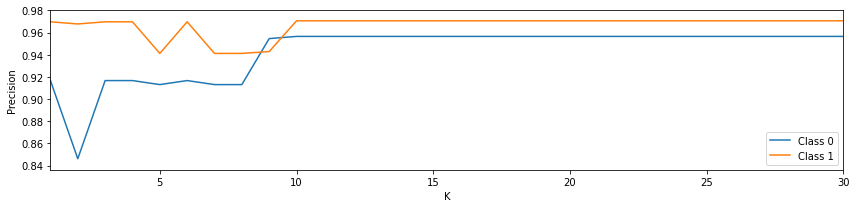

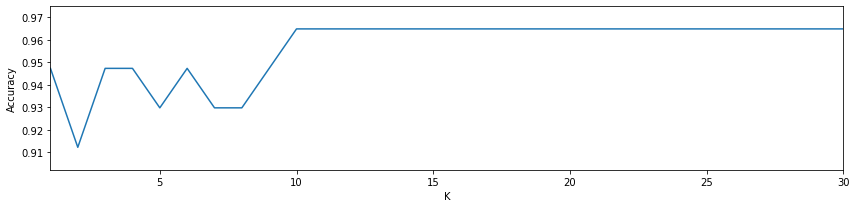

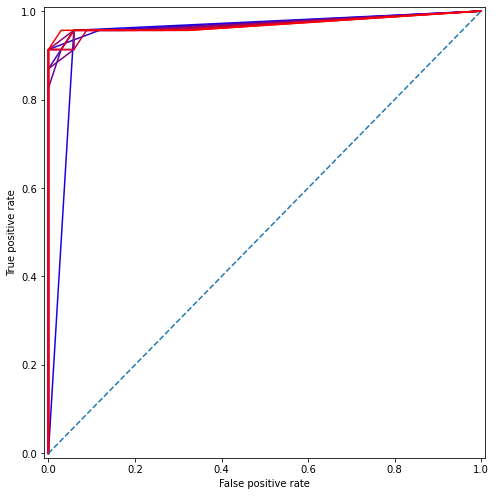

In [13]:
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)

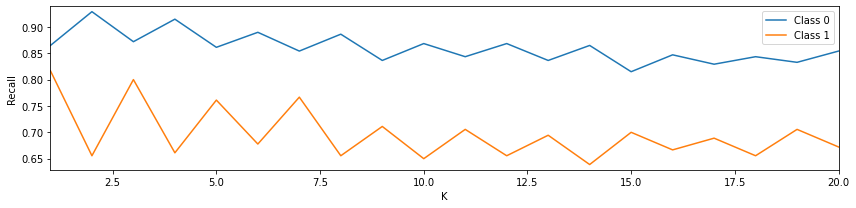

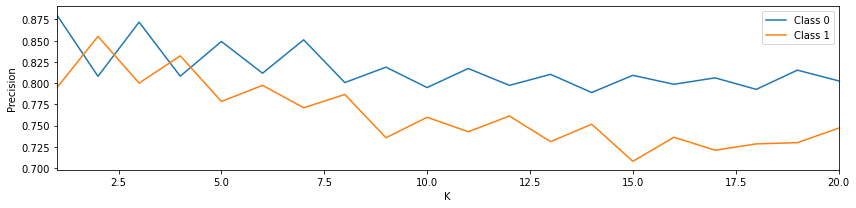

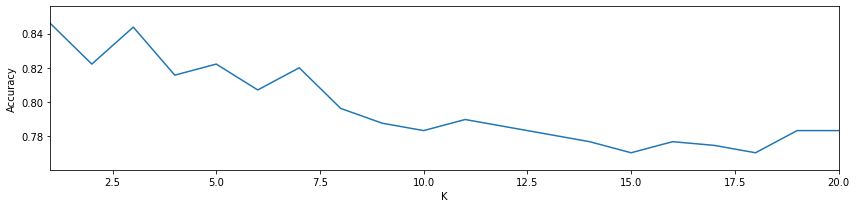

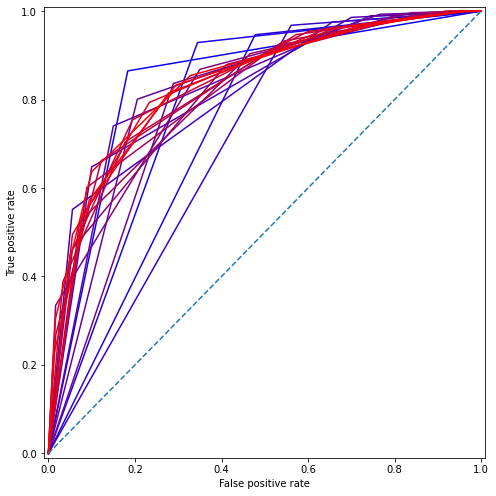

In [14]:
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)